In [1]:
from psmc.model import PSMC
from psmc.plot import plot_history
from psmc.utils import process_ts
import numpy as np 
import matplotlib.pyplot as plt
import msprime
import demes
import demesdraw

## Test run on simulated data

This example mirrors the code in the main [example.ipynb]() notebook, but where _ms_ is replaced with the [msprime](https://tskit.dev/msprime/docs/latest/intro.html) simulator, a fast and more flexible equivalent that has a python interface. Demograpies are converted into [demes](https://popsim-consortium.github.io/demes-spec-docs/main/introduction.html) format from the commands in [simulations/ms-commands.txt](simulations/ms-commands.txt), which allows for easy plotting.

_Msprime_ outputs a _tskit_ [tree sequence](https://tskit.dev/tutorials/what_is.html), which is converted into an array suitable for reading into the Expectation-Maximization (EM) algorithm. This conversion can also be done using tree sequences that represent real data, or simulations from [stdpopsim](https://popsim-consortium.github.io/stdpopsim-docs/stable/index.html).

Ignoring unknown args: ['ms', '2', '100', '-t', '30000', '-r', '6000', '30000000', '-p', '8']


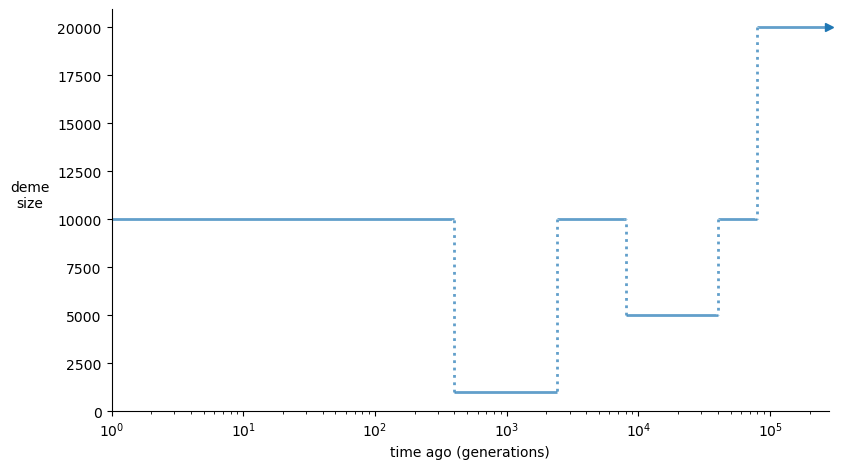

In [2]:
### Run simulation
with open('simulations/ms-commands.txt', 'r') as f:
    cmds = f.readlines()
n0 = 1e4
rho = 6000 / 30_000_000 / (4 * n0)  # equivalent of the "-r" flag
mu = 30000 / 30_000_000 / (4 * n0)  # equivalent of the "-t" flag
demes_obj = demes.from_ms(cmds[0], N0=n0)
demography = msprime.Demography.from_demes(demes_obj)
# NB - could equivalently run 3 replicate simulations from the ms-commands.txt lines by using mspms
ts = msprime.sim_ancestry(1, demography=demography, sequence_length=90e6, recombination_rate=rho, random_seed=123)
ts = msprime.sim_mutations(ts, rate=mu, random_seed=123)
demesdraw.size_history(demes_obj, log_time=True);


### Brief overview of PSMC

PSMC (Pairwise Sequentially Markovian Coalescent) is a computational model that leverages coalescent theory to infer past population size dynamics by analyzing the genomic sequence heterozygosity. 

Over generations, our genetic material undergoes mutation and recombination processes. While mutations provide a means to estimate the time since divergence, recombination facilitates the exchange of genetic information between chromosome sets, preserving fragments of parental variation for future generations. Consequently, our chromosomes are composed of numerous fragments. When examined in conjunction with our diploid set, these fragments enable the tracing of our genetic heritage back to thousands of most recent common ancestors (MRCAs).Coalescent theory presents a direct relationship between the effective population size ($N_e$) at a given time and the probability of coalescence events: larger populations exhibit lower probabilities, while population bottlenecks result in an increased number of coalescence events (MRCAs) for the corresponding time period.

However, in practice, we are unable to pinpoint where crossover breakpoints occur. To address this, the authors developed a sequential hidden Markov model (HMM) that establishes a direct connection between population size history and genome sequence heterozygosity. The model's innovation lies in formulating the necessary mathematics to define this HMM, assuming a Markovian process. Although a strong assumption, the resulting model has proven to be both effective and useful.

Due to the extensive length of the genome sequence, calculating the probabilities of latent variables is computationally demanding. To make this process more manageable, the EM algorithm is employed. Rather than directly maximizing the likelihood, the EM algorithm optimizes a computationally efficient lower bound. This implementation of PSMC uses numpy (and a bit of numba) to approach the speed of the original C code.

### Run EM 

The equivalent of the example in `example.ipynb`

In [3]:
# get an `x` object for input into psmc-python - this will have only one replicate
x = process_ts(ts, progress=True)
print(f"Using {x.shape[1]} 100bp windows")

# initialise new instance and run EM
theta0 = np.sum(x) / (x.shape[0] * x.shape[1])
rho0 = theta0 / 5

psmc_model = PSMC(t_max=15, n_steps=64, pattern='1*4+25*2+1*4+1*6')
psmc_model.param_recalculate()

initial_params = [theta0, rho0, 15] + [1.] * (psmc_model.n_free_params - 3)
bounds = [(1e-4, 1e-1), (1e-5, 1e-1), (12, 20)] + [(0.1, 10)] * (psmc_model.n_free_params - 3)
loss_list, params_history = psmc_model.EM(initial_params, bounds, x=x, n_iter=10)

Calc 100bp windows:   0%|          | 0/899999 [00:00<?, ?it/s]

Using 900000 100bp windows


In [4]:
#save model params
psmc_model.save_params('./checkpoints/test.json')

In [5]:
#load model params
psmc_model = PSMC()
psmc_model.load_params('./checkpoints/test.json')

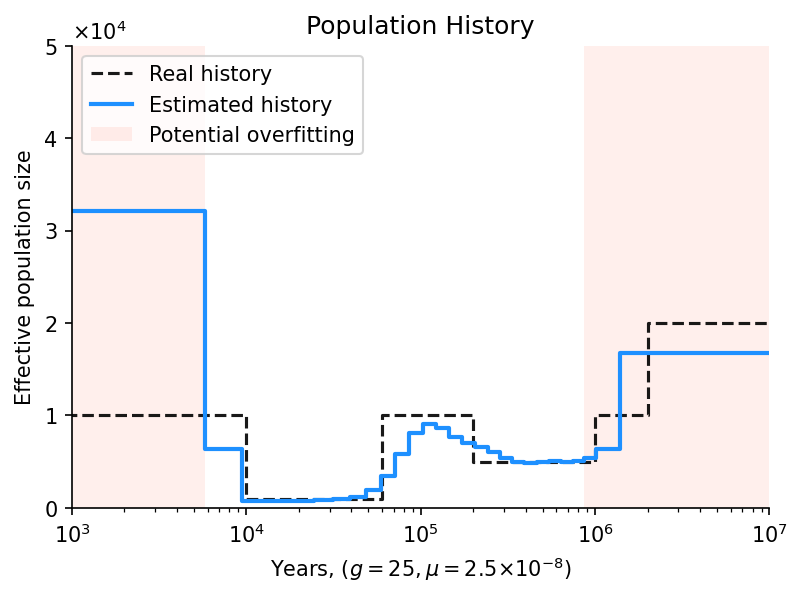

In [6]:
# Put the population size history into an array of the expected shape for plot_history
# by querying the `demes` object for times and sizes
sim_history = np.array([
    (e['end_time'] / n0 / 4, e['start_size'] / n0)
    for e in reversed(demes_obj.asdict()["demes"][0]["epochs"])
])
plot_history(psmc_model, x, sim_history, n0_sim=1e4, th=20)


This is not a perfect match, but pretty amazing given that it was trained on only 90Mb of the synthetic genome

## Inference on real genome data

Here's an example using data from the Human Genome Diversity Project. The raw data is downloaded from https://zenodo.org/records/5495535, a release of tree sequences combining publicly available genomes from [Wohns et al. (2021)](http://dx.doi.org/10.1126/science.abi8264).


In [7]:
# Download the tree sequence file
import json
from urllib.request import urlretrieve
from tqdm.notebook import tqdm
import tszip

chr="17_q"  # Q arm of chr 17
file = f"hgdp_tgp_sgdp_chr{chr}.dated.trees.tsz"

class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize
with TqdmUpTo(unit = 'B', unit_scale = True, unit_divisor = 1024, miniters = 1, desc = file) as t:
    urlretrieve(f"https://zenodo.org/records/5495535/files/{file}", filename=file, reporthook = t.update_to)


hgdp_tgp_sgdp_chr17_q.dated.trees.tsz: 0.00B [00:00, ?B/s]

In [8]:
# Open and pick some selected genomes
ts = tszip.decompress(file).trim()  # remove the missing flanking regions
# Use the HGDP data
use_pops = {"Biaka", "Mbuti", "San", "Japanese", "Uygur", "French"}
all_pops = set()
individuals = {}
for i in ts.individuals():
    metadata = json.loads(i.metadata.decode())
    #if metadata.get("individual_id", "").startswith("HG"):
    if metadata.get("sample", "").startswith("HGDP"):
        # This is an HGDP individual (could also try with SGDP or 1000genomes)
        pop = ts.population(ts.node(i.nodes[0]).population)
        pop_metadata = json.loads(pop.metadata.decode())
        name = pop_metadata["name"]
        all_pops.add(name)
        if name in use_pops:
            print(f"Using {metadata['sample']} from {pop_metadata}")
            individuals[name + "-" + pop_metadata["region"]] = i.id
            use_pops.remove(name)

print(f"Couldn't find {use_pops} in {all_pops}" if len(use_pops) else f"Individual IDs: {individuals}")

fns = {}
for pop, i in individuals.items():
    x = process_ts(ts, individual=i, progress=True)
    theta0 = np.sum(x) / (x.shape[0] * x.shape[1])
    rho0 = theta0 / 5
    
    psmc_model = PSMC(t_max=15, n_steps=64, pattern='1*4+25*2+1*4+1*6')
    psmc_model.param_recalculate()
    
    initial_params = [theta0, rho0, 15] + [1.] * (psmc_model.n_free_params - 3)
    bounds = [(1e-4, 1e-1), (1e-5, 1e-1), (12, 20)] + [(0.1, 10)] * (psmc_model.n_free_params - 3)
    loss_list, params_history = psmc_model.EM(initial_params, bounds, x=x, n_iter=10)
    fns[pop] = f"./checkpoints/{pop}-HDGP.json"
    print(f"Saved result to {fns[pop]}")
    psmc_model.save_params(fns[pop])

Using HGDP00479 from {'name': 'Biaka', 'region': 'AFRICA'}
Using HGDP00471 from {'name': 'Mbuti', 'region': 'AFRICA'}
Using HGDP01299 from {'name': 'Uygur', 'region': 'CENTRAL_SOUTH_ASIA'}
Using HGDP01029 from {'name': 'San', 'region': 'AFRICA'}
Using HGDP00747 from {'name': 'Japanese', 'region': 'EAST_ASIA'}
Using HGDP00536 from {'name': 'French', 'region': 'EUROPE'}
Individual IDs: {'Biaka-AFRICA': 1, 'Mbuti-AFRICA': 3, 'Uygur-CENTRAL_SOUTH_ASIA': 42, 'San-AFRICA': 133, 'Japanese-EAST_ASIA': 226, 'French-EUROPE': 385}


Calc 100bp windows:   0%|          | 0/562039 [00:00<?, ?it/s]

Saved result to ./checkpoints/Biaka-AFRICA-HDGP.json


Calc 100bp windows:   0%|          | 0/562039 [00:00<?, ?it/s]

Saved result to ./checkpoints/Mbuti-AFRICA-HDGP.json


Calc 100bp windows:   0%|          | 0/562039 [00:00<?, ?it/s]

Saved result to ./checkpoints/Uygur-CENTRAL_SOUTH_ASIA-HDGP.json


Calc 100bp windows:   0%|          | 0/562039 [00:00<?, ?it/s]

Saved result to ./checkpoints/San-AFRICA-HDGP.json


Calc 100bp windows:   0%|          | 0/562039 [00:00<?, ?it/s]

Saved result to ./checkpoints/Japanese-EAST_ASIA-HDGP.json


Calc 100bp windows:   0%|          | 0/562039 [00:00<?, ?it/s]

Saved result to ./checkpoints/French-EUROPE-HDGP.json


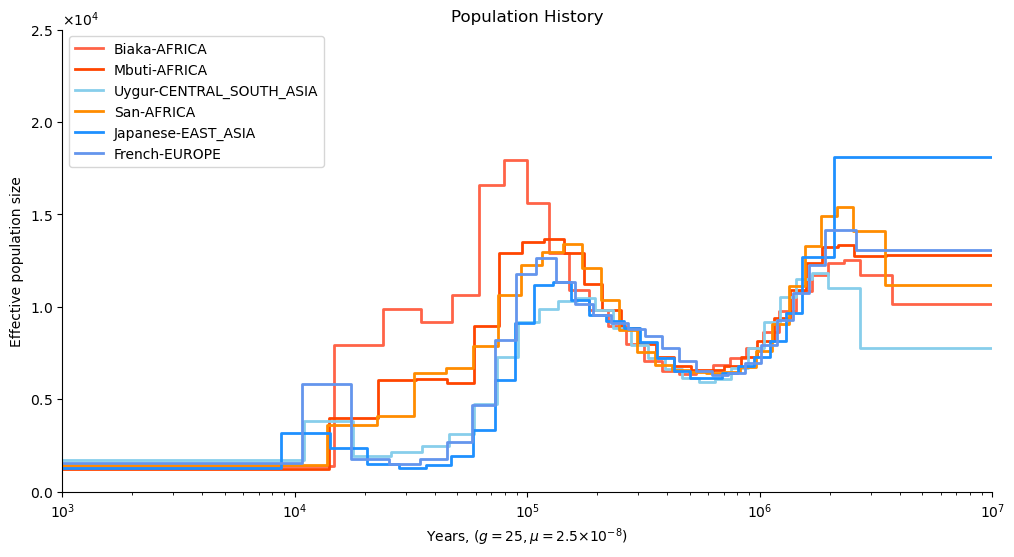

In [9]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
psmc = PSMC()
afr_colours = iter(('tomato', 'orangered', 'darkorange'))
other_colours = iter(('skyblue', 'dodgerblue', 'cornflowerblue'))
for pop, fn in fns.items():
    color=next(afr_colours if pop.endswith("AFRICA") else other_colours)
    psmc.load_params(fn)
    plot_history(psmc, th=20, axs=axs, label=pop, color=color)
        
axs.set_ylim(0,2.5e4);